In [67]:
import torch
from pytorch_metric_learning import losses
import data_handler
from siamese_network import SiameseNetwork, train, test
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from custom_losses import ContrastiveLoss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import itertools as it

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
device = torch.device(2)

# Data Management

In [26]:
df_data, _ = data_handler.load(path="dataset/", filename_train="train.csv", sep_char='#')

In [27]:
df_data.head()

,arg_id,argument,key_point_id,key_point,topic,stance,label
0,arg_11_122,we shouldn't ban human cloning for risk the vi...,kp_11_0,Cloning can be used for organ replication,We should ban human cloning,-1,0.0
1,arg_13_95,use of child actors gives us a lot of great sh...,kp_13_2,Child performers are necessary for roles,We should ban the use of child actors,-1,1.0
2,arg_18_186,urbanization leads to deforestation and increa...,kp_18_5,Urbanization harms the environment,We should fight urbanization,1,1.0
3,arg_0_13,assisted suicide gives people control over the...,kp_0_2,People should have the freedom to choose to en...,Assisted suicide should be a criminal offence,-1,1.0
4,arg_25_128,"journalism is a public good, that it has broad...",kp_25_5,Subsidy increases objectivity in reporting,We should subsidize journalism,1,0.0


In [28]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arg_id        20635 non-null  object 
 1   argument      20635 non-null  object 
 2   key_point_id  20635 non-null  object 
 3   key_point     20635 non-null  object 
 4   topic         20635 non-null  object 
 5   stance        20635 non-null  int64  
 6   label         20635 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.1+ MB


In [29]:
df_data['label'].value_counts()

0.0    16375
1.0     4260
Name: label, dtype: int64

<AxesSubplot: title={'center': 'Labels Proportions in Dataset'}>

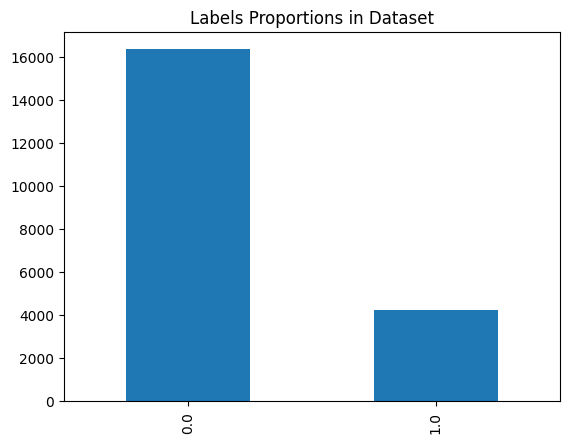

In [30]:
df_data['label'].value_counts().plot.bar(title='Labels Proportions in Dataset')

In [31]:
# Perform a stratified split dividing it into 80% training set and 20% validation set
df_train, df_val = data_handler.split_train_data(df_data, perc_split=0.8)

zero_train:  13100
one_train:  3408
zero_val:  3275
one_val:  852


In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16508 entries, 0 to 16471
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arg_id        16508 non-null  object 
 1   argument      16508 non-null  object 
 2   key_point_id  16508 non-null  object 
 3   key_point     16508 non-null  object 
 4   topic         16508 non-null  object 
 5   stance        16508 non-null  int64  
 6   label         16508 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.0+ MB


In [33]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4127 entries, 16520 to 20634
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arg_id        4127 non-null   object 
 1   argument      4127 non-null   object 
 2   key_point_id  4127 non-null   object 
 3   key_point     4127 non-null   object 
 4   topic         4127 non-null   object 
 5   stance        4127 non-null   int64  
 6   label         4127 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 257.9+ KB


<AxesSubplot: title={'center': 'Labels Proportions in Training set'}>

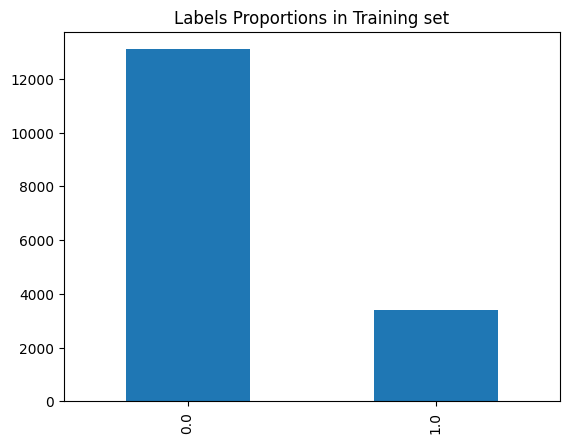

In [34]:
df_train['label'].value_counts().plot.bar(title='Labels Proportions in Training set')

<AxesSubplot: title={'center': 'Labels Proportions in Validation set'}>

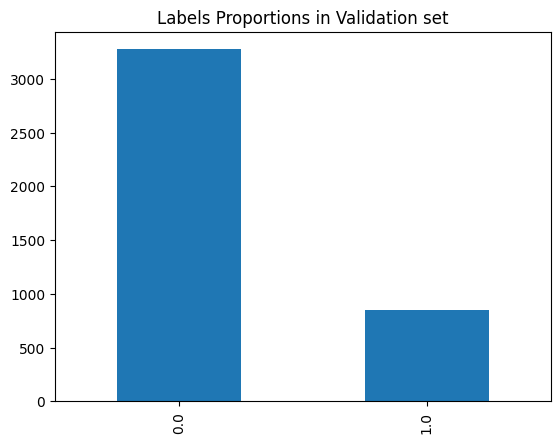

In [35]:
df_val['label'].value_counts().plot.bar(title='Labels Proportions in Validation set')

In [36]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train)
df_val = data_handler.concatenate_topics(df_val)

In [37]:
df_train.label

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
16503    1.0
16504    1.0
16505    1.0
16506    1.0
16507    1.0
Name: label, Length: 16508, dtype: float64

In [39]:
df_train.info()
print('--------')
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16508 entries, 0 to 16507
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         16508 non-null  int64  
 1   arg_id        16508 non-null  object 
 2   argument      16508 non-null  object 
 3   key_point_id  16508 non-null  object 
 4   stance        16508 non-null  int64  
 5   label         16508 non-null  float64
 6   key_points    16508 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 902.9+ KB
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4127 entries, 0 to 4126
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         4127 non-null   int64  
 1   arg_id        4127 non-null   object 
 2   argument      4127 non-null   object 
 3   key_point_id  4127 non-null   object 
 4   stance        4127 non-null   int64  
 5   label         4127 n

In [40]:
df_train = df_train[12850:13350]
df_train = df_train.reset_index()
#df_train[:100]

In [41]:
n_words = pd.DataFrame()
n_words['words_per_arg_train'] = df_train['argument'].str.split().apply(len)
n_words['words_per_arg_val'] = df_val['argument'].str.split().apply(len)
n_words['words_per_kp_train'] = df_train['key_points'].str.split().apply(len)
n_words['words_per_kp_val'] = df_val['key_points'].str.split().apply(len)

Considerazioni varie...

<AxesSubplot: >

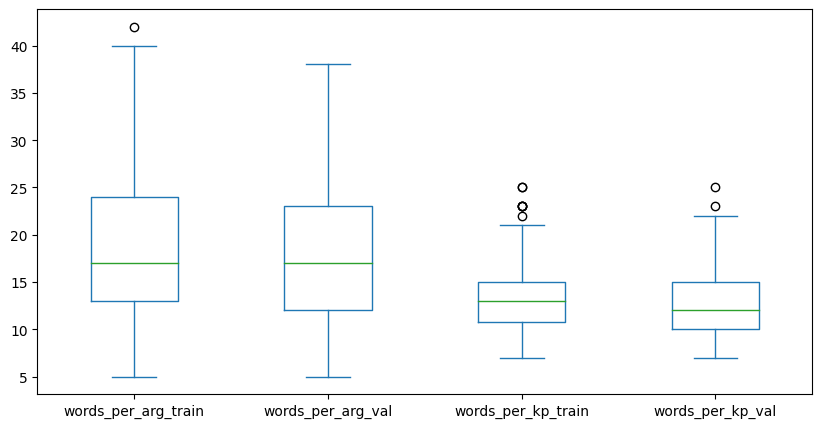

In [42]:
n_words.plot.box(figsize=(10, 5))

In [44]:
# Load our model's (bert-base-uncased) tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize data
columns_list = ['argument', 'key_points', 'label']
tokenized_tr = data_handler.tokenize_df(df_train[columns_list], tokenizer, max_length=60)
tokenized_val = data_handler.tokenize_df(df_val[columns_list], tokenizer, max_length=60)

/storagenfs/a.capurso1/HLTKeyPointAnalysis/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/storagenfs/a.capurso1/HLTKeyPointAnalysis/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `

In [45]:
print(f'Vocabulary size of tokenizer:', tokenizer.vocab_size, '\nContext size:', tokenizer.model_max_length)

Vocabulary size of tokenizer: 30522 
Context size: 512


In [48]:
model = SiameseNetwork(bert_type=BertModel.from_pretrained('bert-base-uncased'))

batch_size = 8

train_loader = DataLoader(tokenized_tr, shuffle=True, batch_size=batch_size, pin_memory=True)

#train_loss = ContrastiveLoss()
train_loss = losses.ContrastiveLoss()

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

# The BERT authors recommend between 2 and 4.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
'''
-y  log(^y) + (1 - y)  log(1 - ^y)
where ^y is the cosine similarity of the embeddings,
and y reflects whether a pair matches (1) or not (0).
'''
def paper_contrastive(cosine, label):
    
    #cosine[cosine == 0] = 1e-8
    #cosine[cosine == 1] = 0.99
    
    log_1 = torch.nan_to_num(torch.log(cosine), nan=-1e5)
    log_2 = torch.nan_to_num(torch.log(1-cosine), nan=-1e5)
    
    #print(f'cosine {log_1.shape} {log_2.shape}')
    
    contr = torch.mul((-label).double(), log_1.double())+ \
            torch.mul((1-label).double(), log_2.double())
    return contr

In [52]:
model.to(device)
5+2
#epoch.to(device)
#train_loader.to(device)
#optimizer.to(device)
#scheduler.to(device)

7

In [ ]:
loss_function = torch.nn.MSELoss()

train(model, device, train_loader, loss_function, optimizer, epochs, scheduler, ['accuracy'])

In [68]:
test_data = DataLoader(tokenized_val[0:10], shuffle=True)

In [74]:
preds = test(model, device, test_data, loss_function, ['accuracy'])

In [76]:
params = {
    'batch_size': [4, 8],
    'loss': [torch.nn.MSELoss()],
    'optimizer': ['adam'],
    'lr': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    'eps': [1e-8, 1e-6, 1e-7, 1e-10],
    'epochs': [2, 3, 4],
    'warmup_steps': [0,1e1,1e2,1e3],
    'weight_decay': [1e-1, 1e-2, 1e-5]
}

In [81]:
def grid_search(train_data, val_data, model_type, params, metrics, device):
    
    keys, values = zip(*params.items())
    combo_list = list(it.product(*(values)))

    
    res_vec = []
    
    for i in tqdm(range(len(combo_list))):
        
        res_dict = {
            'batch_size': combo_list[i][0],
            'loss': combo_list[i][1],
            'optimizer': combo_list[i][2],
            'lr': combo_list[i][3],
            'eps': combo_list[i][4],
            'epochs': combo_list[i][5],
            'warmup_steps': combo_list[i][6],
            'weight_decay' : combo_list[i][7]
        }
        
        model = SiameseNetwork(bert_type=BertModel.from_pretrained(model_type))
        model.to(device)
        
        train_loader = DataLoader(train_data, shuffle=True, batch_size=res_dict['batch_size'], pin_memory=True)
        
        optimizer=res_dict['optimizer']
        
        if(optimizer == 'adam'):
            optimizer= torch.optim.AdamW(model.parameters(),
                  lr = res_dict['lr'], 
                  eps = res_dict['eps'] 
        )
            
        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        total_steps = len(train_loader) * res_dict['epochs']

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = res_dict['warmup_steps'],
                                            num_training_steps = total_steps)
        
        train_res = train(model, device, train_loader, res_dict['loss'], optimizer, res_dict['epochs'], scheduler, metrics, verbose=False)
        #train(model, device, train_loader, res_dict['loss'], optimizer, res_dict['epochs'], scheduler, log=False)
        
        
        val_loader = DataLoader(val_data, shuffle=True, pin_memory=True)
        
        #val_res = test(model, device, val_loader, res_dict['loss'], res_dict['metric'])
        test(model, device, val_loader, res_dict['loss'], metrics)
        
        #res_dict['train_score'] = train_res
        #res_dict['val_score'] = val_res
        res_vec.append(res_dict)
        
    return res_vec   
        

In [ ]:
from siamese_network import SiameseNetwork
res_vec = grid_search(tokenized_tr, tokenized_val, 'bert-base-uncased', params, ['accuracy'], device)

In [39]:
len(train_loader.dataset)

500